In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
import torchvision as tv
from torch import nn, optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 64

if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

In [86]:
import shutil

source_path = "./data/minifigures/"


def get_current_i(path: os.path):
    i = 0
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            i += 1
    return i


def convert():
    for class_ in os.listdir(source_path):
        new_dir = os.path.join(source_path, class_)
        for sub_class in os.listdir(new_dir):
            sub_class_path = os.path.join(new_dir, sub_class)
            if os.path.isfile(sub_class_path):
                if sub_class == ".DS_Store":
                    os.remove(os.path.join(sub_class_path))
            else:
                for class_i in os.listdir(sub_class_path):
                    if class_i.endswith(".jpg"):
                        new_path = os.path.join(
                            new_dir, f"{get_current_i(new_dir)}.jpg"
                        )
                        shutil.move(os.path.join(sub_class_path, class_i), new_path)
            shutil.rmtree(sub_class_path)


def convert_to_one():
    for class_ in os.listdir(source_path):
        new_dir = os.path.join(source_path, class_)
        for class_i in os.listdir(new_dir):
            if class_i.endswith(".jpg"):
                new_path = os.path.join(source_path, f"{get_current_i(source_path)}.jpg")
                shutil.move(os.path.join(new_dir, class_i), new_path)
        shutil.rmtree(new_dir)

In [87]:
random_transforms = [
    tv.transforms.ColorJitter(),
    tv.transforms.RandomRotation(degrees=20),
]
data_transforms = tv.transforms.Compose(
    [
        tv.transforms.Resize(IMAGE_SIZE),
        tv.transforms.CenterCrop(IMAGE_SIZE),
        tv.transforms.RandomHorizontalFlip(p=0.5),
        tv.transforms.RandomApply(random_transforms, p=0.2),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [88]:
data_dir = f"{os.path.abspath(os.curdir)}/data/celebs"

dataset = tv.datasets.ImageFolder(f"{data_dir}", data_transforms)

train_size = int(1 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)
classes = dataset.classes
print("Classes: ", classes)
print("The datasest have: ", len(dataset), " images")

Classes:  ['celebs']
The datasest have:  9999  images


In [89]:
TRAIN_DATA_LOADER = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

TEST_DATA_LOADER = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)


print(DEVICE)

mps


In [90]:
def show_images(imgs, n_images):
    for i in range(n_images):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(imgs[i])
        plt.xticks([])
        plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


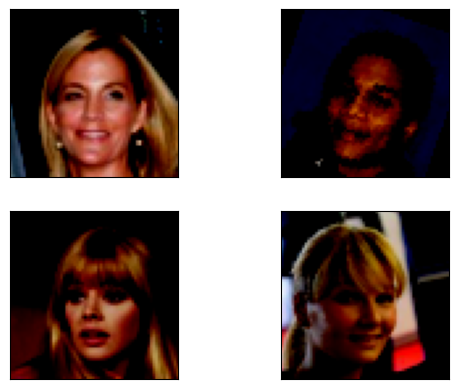

In [91]:
imgs_, _ = next(iter(TRAIN_DATA_LOADER))
show_images(imgs_.numpy().transpose(0, 2, 3, 1), 4)

In [92]:
def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss - EPOCH " + str(history["epochs"]))
    plt.plot(range(history['epochs']), history['gen_losses'], label="Generator loss")
    plt.plot(range(history['epochs']), history['dis_losses'], label="Discriminator loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [93]:
from torchsummary import summary

def show_generator_arch(generator, num_zeroes):
    noise = torch.randn(BATCH_SIZE, num_zeroes, 1, 1, device=DEVICE)
    generator = generator(nz=num_zeroes, channels=3).to(DEVICE)
    summary(generator, noise)

def show_discriminator_arch(discriminator):
    discriminator = discriminator(channels=3).to(DEVICE)
    summary(discriminator, imgs_)

In [94]:
def get_generated_img(nz, generator):
    noise = torch.randn(1, nz, 1, 1, device=DEVICE)
    gen_image = generator(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    return gen_image

In [95]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()

        self.nz = nz
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(
                    n_input,
                    n_output,
                    kernel_size=k_size,
                    stride=stride,
                    padding=padding,
                    bias=False,
                ),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(
                self.nz, 1024, 4, 1, 0
            ),  # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img


class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [
                nn.Conv2d(
                    n_input,
                    n_output,
                    kernel_size=k_size,
                    stride=stride,
                    padding=padding,
                    bias=False,
                )
            ]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)

        return out.view(-1, 1)

In [96]:
from matplotlib.animation import FuncAnimation, PillowWriter


def make_gif(history, filename: str):
    fig = plt.figure(figsize=(10, 10))
    im = plt.imshow(np.zeros((IMAGE_SIZE, IMAGE_SIZE)))
    plt.grid(None)
    plt.title(f"Epoch: {history["figs_epochs"][0]}")

    def update(i):
        im.set_array(history["figs"][i])
        im.axes.set_title(f"Epoch: {history["figs_epochs"][i]}")
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im

    ani = FuncAnimation(fig, update, repeat=True, frames=len(history["figs"]), interval=50)
    writer = PillowWriter(fps=5, metadata=dict(artist="Me"), bitrate=1800)
    ani.save(filename, writer=writer)


In [97]:
def train_model(
    discriminator, generator, loss_func, optimizer_d, optimizer_g, num_zeroes, history
):
    epochloop = tqdm(range(history["epochs"]), position=0, desc="Training", leave=False)
    real_label = 0.95
    fake_label = 0
    for epoch in epochloop:
        dis_loss = 0.0
        gen_loss = 0.0
        for _, (real_images, _) in enumerate(TRAIN_DATA_LOADER, start=1):
            discriminator.zero_grad()
            real_images = real_images.to(DEVICE)
            batch_size = real_images.size(0)
            labels = torch.full((batch_size, 1), real_label, device=DEVICE)

            output = discriminator(real_images)
            errD_real = loss_func(output, labels)
            errD_real.backward()
            output.mean().item()
            noise = torch.randn(batch_size, num_zeroes, 1, 1, device=DEVICE)
            fake = generator(noise)

            labels.fill_(fake_label)
            temp = fake.detach()
            output = discriminator(temp)
            errD_fake = loss_func(output, labels)
            errD_fake.backward()
            output.mean().item()
            dis_loss += (errD_real.item() + errD_fake.item()) / 2
            optimizer_d.step()

            generator.zero_grad()
            labels.fill_(real_label)
            output = discriminator(fake)
            errG = loss_func(output, labels)
            gen_loss += errG.item()
            errG.backward()

            output.mean().item()
            optimizer_g.step()
        if epoch % 1 == 0:
            # show_generated_img(num_zeroes, generator)
            history["figs"].append(get_generated_img(num_zeroes, generator))
            history["figs_epochs"].append(epoch + 1)
        history["dis_losses"].append(dis_loss / len(TRAIN_DATA_LOADER))
        history["gen_losses"].append(gen_loss / len(TRAIN_DATA_LOADER))

In [98]:
show_discriminator_arch(Discriminator)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 32, 32, 32]          1,536
|    └─LeakyReLU: 2-2                    [-1, 32, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 64, 16, 16]          32,768
|    └─LeakyReLU: 2-4                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-5                       [-1, 128, 8, 8]           131,072
|    └─BatchNorm2d: 2-6                  [-1, 128, 8, 8]           256
|    └─LeakyReLU: 2-7                    [-1, 128, 8, 8]           --
|    └─Conv2d: 2-8                       [-1, 256, 4, 4]           524,288
|    └─BatchNorm2d: 2-9                  [-1, 256, 4, 4]           512
|    └─LeakyReLU: 2-10                   [-1, 256, 4, 4]           --
|    └─Conv2d: 2-11                      [-1, 1, 1, 1]             4,096
Total params: 694,528
Trainable params: 694,528
Non-trainable p

In [99]:
show_generator_arch(Generator, 256)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 1024, 4, 4]          4,194,304
|    └─BatchNorm2d: 2-2                  [-1, 1024, 4, 4]          2,048
|    └─ReLU: 2-3                         [-1, 1024, 4, 4]          --
|    └─ConvTranspose2d: 2-4              [-1, 512, 8, 8]           8,388,608
|    └─BatchNorm2d: 2-5                  [-1, 512, 8, 8]           1,024
|    └─ReLU: 2-6                         [-1, 512, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 256, 16, 16]         2,097,152
|    └─BatchNorm2d: 2-8                  [-1, 256, 16, 16]         512
|    └─ReLU: 2-9                         [-1, 256, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 128, 32, 32]         524,288
|    └─BatchNorm2d: 2-11                 [-1, 128, 32, 32]         256
|    └─ReLU: 2-12                        [-1, 128, 

In [113]:
def task():
    LR_G = 0.001
    LR_D = 0.0005
    beta1 = 0.5
    epochs = 50
    num_zeroes = 256
    generator = Generator(nz=num_zeroes, channels=3).to(DEVICE)
    discriminator = Discriminator(channels=3).to(DEVICE)

    criterion = nn.BCELoss()

    optimizerD = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(beta1, 0.999))
    optimizerG = optim.Adam(generator.parameters(), lr=LR_G, betas=(beta1, 0.999))

    history = {
        "gen_losses": [],
        "dis_losses": [],
        "figs": [],
        "figs_epochs": [],
        "epochs": epochs,
    }

    train_model(
        discriminator, generator, criterion, optimizerD, optimizerG, num_zeroes, history
    )
    return history

history_1 = task()

Training:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

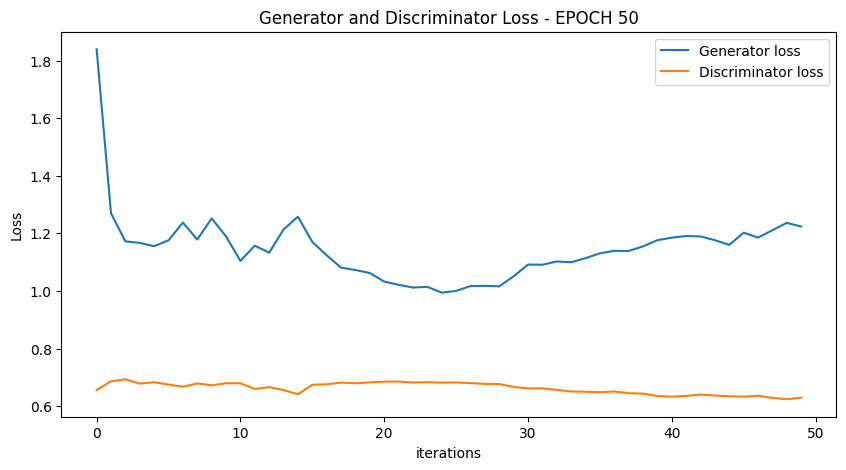

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

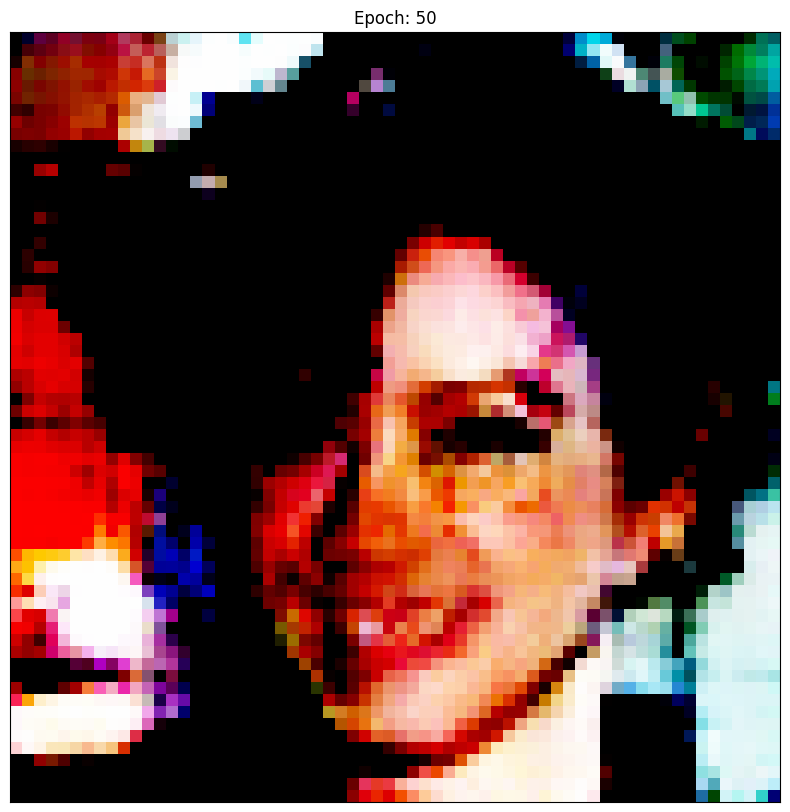

In [116]:
plot_loss(history_1)
make_gif(history_1, "./results/1.gif")

In [119]:
%%html
<img src="./results/1.gif" width="512" align="center">

In [ ]:
class Generator2(nn.Module):
    def __init__(self, nz=256, channels=3):
        super(Generator2, self).__init__()
        ngf = 64
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, channels, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)


class Discriminator2(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator2, self).__init__()

        self.channels = channels

        def convlayer(
            n_input, n_output, k_size=4, stride=2, padding=0, bn=False, dp=False
        ):
            block = [
                nn.Conv2d(
                    n_input,
                    n_output,
                    kernel_size=k_size,
                    stride=stride,
                    padding=padding,
                    bias=False,
                )
            ]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            if dp:
                block.append(nn.Dropout(0.3))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1, dp=True),
            *convlayer(64, 128, 4, 2, 1, bn=True, dp=True),
            *convlayer(128, 256, 4, 2, 1, bn=True, dp=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)

        return out.view(-1, 1)

In [ ]:
show_generator_arch(Generator2, 256)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 3

In [ ]:
show_discriminator_arch(Discriminator2)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 32, 32, 32]          1,536
|    └─LeakyReLU: 2-2                    [-1, 32, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 64, 16, 16]          32,768
|    └─Dropout: 2-4                      [-1, 64, 16, 16]          --
|    └─LeakyReLU: 2-5                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-6                       [-1, 128, 8, 8]           131,072
|    └─BatchNorm2d: 2-7                  [-1, 128, 8, 8]           256
|    └─Dropout: 2-8                      [-1, 128, 8, 8]           --
|    └─LeakyReLU: 2-9                    [-1, 128, 8, 8]           --
|    └─Conv2d: 2-10                      [-1, 256, 4, 4]           524,288
|    └─BatchNorm2d: 2-11                 [-1, 256, 4, 4]           512
|    └─Dropout: 2-12                     [-1, 256, 4, 4]          

In [ ]:
def task_2():
    LR_G = 0.001
    LR_D = 0.0005
    beta1 = 0.5
    epochs = 50
    num_zeroes = 256
    generator = Generator2(nz=num_zeroes, channels=3).to(DEVICE)
    discriminator = Discriminator2(channels=3).to(DEVICE)

    criterion = nn.BCELoss()

    optimizerD = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(beta1, 0.999))
    optimizerG = optim.Adam(generator.parameters(), lr=LR_G, betas=(beta1, 0.999))

    history = {
        "gen_losses": [],
        "dis_losses": [],
        "figs": [],
        "figs_epochs": [],
        "epochs": epochs,
    }

    train_model(
        discriminator, generator, criterion, optimizerD, optimizerG, num_zeroes, history
    )
    return history

history_2 = task_2()

Training:   0%|          | 0/50 [00:00<?, ?it/s]

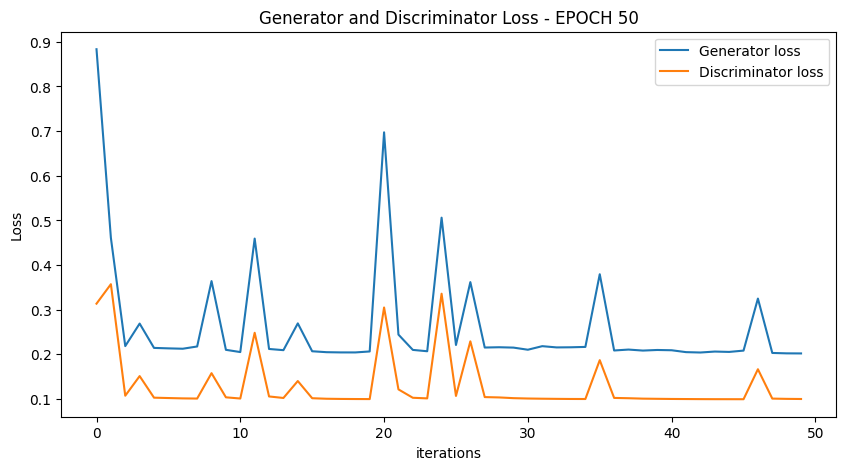

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

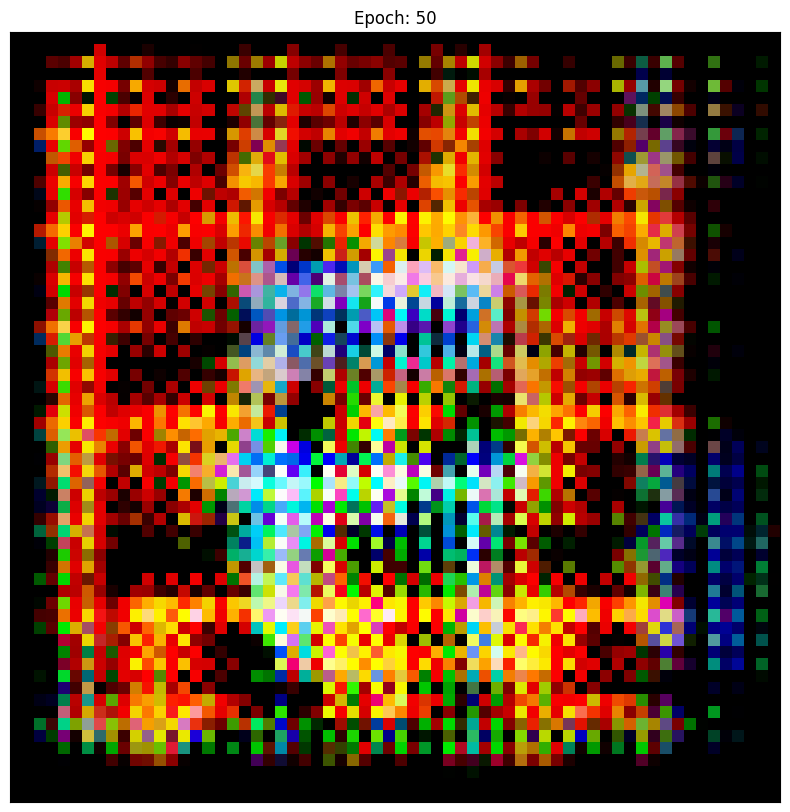

In [ ]:
plot_loss(history_2)
make_gif(history_2, "./results/2.gif")

In [ ]:
%%html
<img src="./results/2.gif" width="512" align="center">

In [107]:
class Generator3(nn.Module):
    def __init__(self, channels, nz):
        super().__init__()
        self.nz = nz
        self.channels = channels
        self.model = nn.Sequential(
            nn.Linear(nz, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, IMAGE_SIZE*IMAGE_SIZE*channels),
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.squeeze(-1).squeeze(-1)
        output = self.model(x)
        output = output.view(x.size(0), self.channels, IMAGE_SIZE, IMAGE_SIZE)
        return output


class Discriminator3(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(IMAGE_SIZE*IMAGE_SIZE*channels, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        output = self.model(x)
        return output

In [109]:
show_discriminator_arch(Discriminator3)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Linear: 2-1                       [-1, 1024]                12,583,936
|    └─ReLU: 2-2                         [-1, 1024]                --
|    └─Dropout: 2-3                      [-1, 1024]                --
|    └─Linear: 2-4                       [-1, 512]                 524,800
|    └─ReLU: 2-5                         [-1, 512]                 --
|    └─Dropout: 2-6                      [-1, 512]                 --
|    └─Linear: 2-7                       [-1, 256]                 131,328
|    └─ReLU: 2-8                         [-1, 256]                 --
|    └─Dropout: 2-9                      [-1, 256]                 --
|    └─Linear: 2-10                      [-1, 1]                   257
|    └─Sigmoid: 2-11                     [-1, 1]                   --
Total params: 13,240,321
Trainable params: 13,240,321
Non-trainabl

In [108]:
show_generator_arch(Generator3, 256)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 12288]               --
|    └─Linear: 2-1                       [-1, 512]                 131,584
|    └─ReLU: 2-2                         [-1, 512]                 --
|    └─Linear: 2-3                       [-1, 1024]                525,312
|    └─ReLU: 2-4                         [-1, 1024]                --
|    └─Linear: 2-5                       [-1, 2048]                2,099,200
|    └─ReLU: 2-6                         [-1, 2048]                --
|    └─Linear: 2-7                       [-1, 12288]               25,178,112
|    └─Tanh: 2-8                         [-1, 12288]               --
Total params: 27,934,208
Trainable params: 27,934,208
Non-trainable params: 0
Total mult-adds (M): 55.84
Input size (MB): 0.03
Forward/backward pass size (MB): 0.12
Params size (MB): 106.56
Estimated Total Size (MB): 106.71


In [110]:
def task_3():
    LR_G = 0.001
    LR_D = 0.0005
    beta1 = 0.5
    epochs = 50
    num_zeroes = 256
    generator = Generator3(nz=num_zeroes, channels=3).to(DEVICE)
    discriminator = Discriminator3(channels=3).to(DEVICE)

    criterion = nn.BCELoss()

    optimizerD = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(beta1, 0.999))
    optimizerG = optim.Adam(generator.parameters(), lr=LR_G, betas=(beta1, 0.999))

    history = {
        "gen_losses": [],
        "dis_losses": [],
        "figs": [],
        "figs_epochs": [],
        "epochs": epochs,
    }

    train_model(
        discriminator, generator, criterion, optimizerD, optimizerG, num_zeroes, history
    )
    return history

history_3 = task_3()

Training:   0%|          | 0/50 [00:00<?, ?it/s]

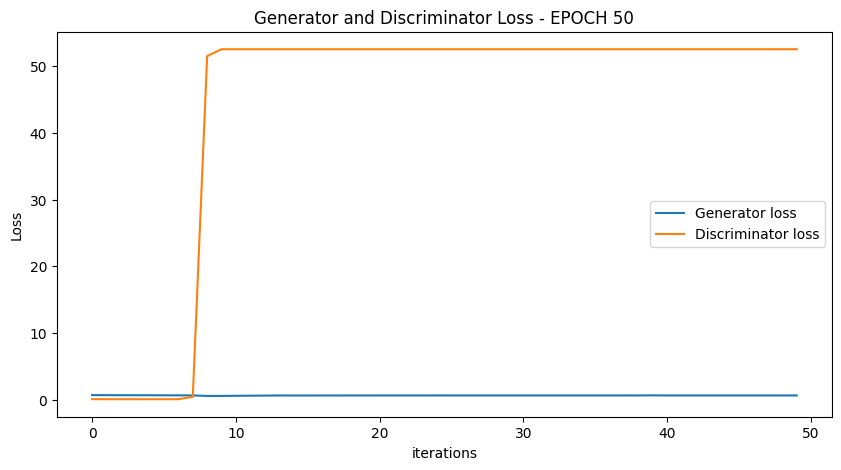

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

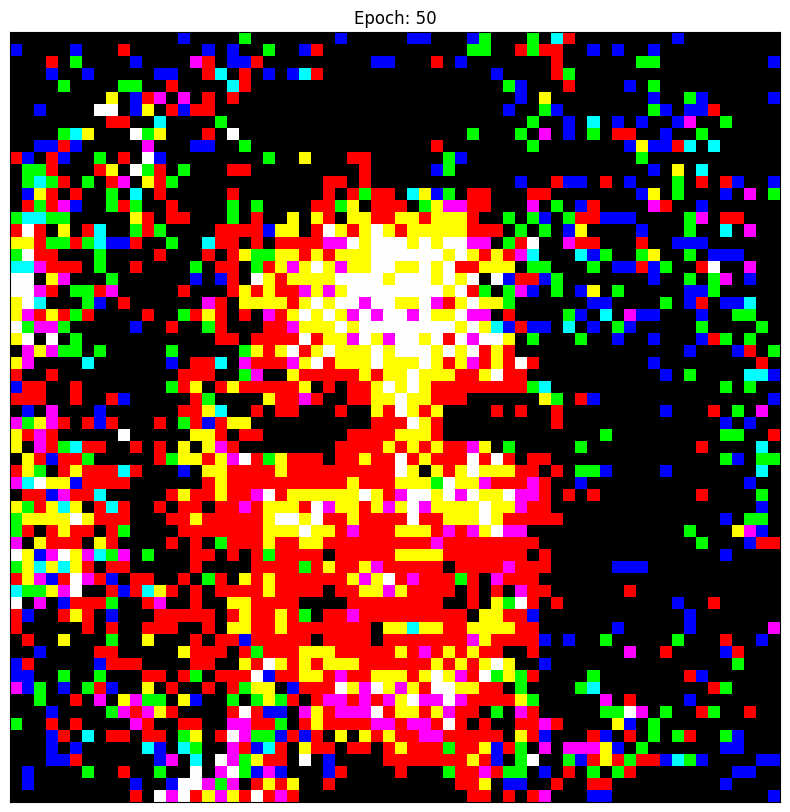

In [111]:
plot_loss(history_3)
make_gif(history_3, "./results/3.gif")

In [120]:
%%html
<img src="./results/3.gif" width="512" align="center">

In [3]:
import functools
import torch.nn.functional as F

def make_layer(block, n_layers):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    return nn.Sequential(*layers)


class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        # mutil.initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x


class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x


class RRDBNet(nn.Module):
    def __init__(self, in_nc, out_nc, nf, nb, gc=32):
        super(RRDBNet, self).__init__()
        RRDB_block_f = functools.partial(RRDB, nf=nf, gc=gc)

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB_block_f, nb)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        #### upsampling
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(fea))
        fea = fea + trunk

        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(fea)))

        return out

# https://github.com/xinntao/ESRGAN

In [14]:
import os.path as osp
import glob
import cv2
import numpy as np
import torch

model = RRDBNet(3, 3, 64, 23, gc=32)
model.to(DEVICE)

model_path = './models/RRDB_ESRGAN_x4.pth'  

test_img_folder = './LR/*'

model = RRDBNet(3, 3, 64, 23, gc=32)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
model = model.to(DEVICE)


idx = 0
for path in glob.glob(test_img_folder):
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)
    # read images
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img * 1.0 / 255
    img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
    img_LR = img.unsqueeze(0)
    img_LR = img_LR.to(DEVICE)

    with torch.no_grad():
        output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
    output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
    output = (output * 255.0).round()
    cv2.imwrite('results/{:s}_rlt.png'.format(base), output)

1 038627
2 038544
3 038587
4 11
5 6
6 3


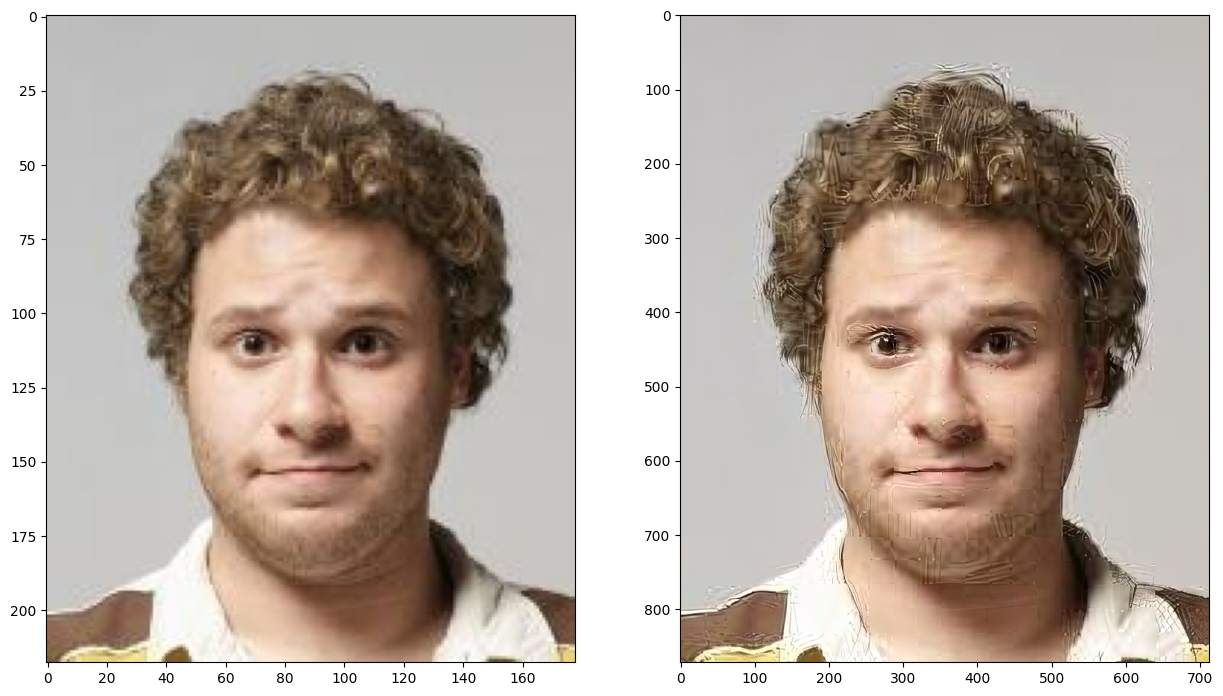

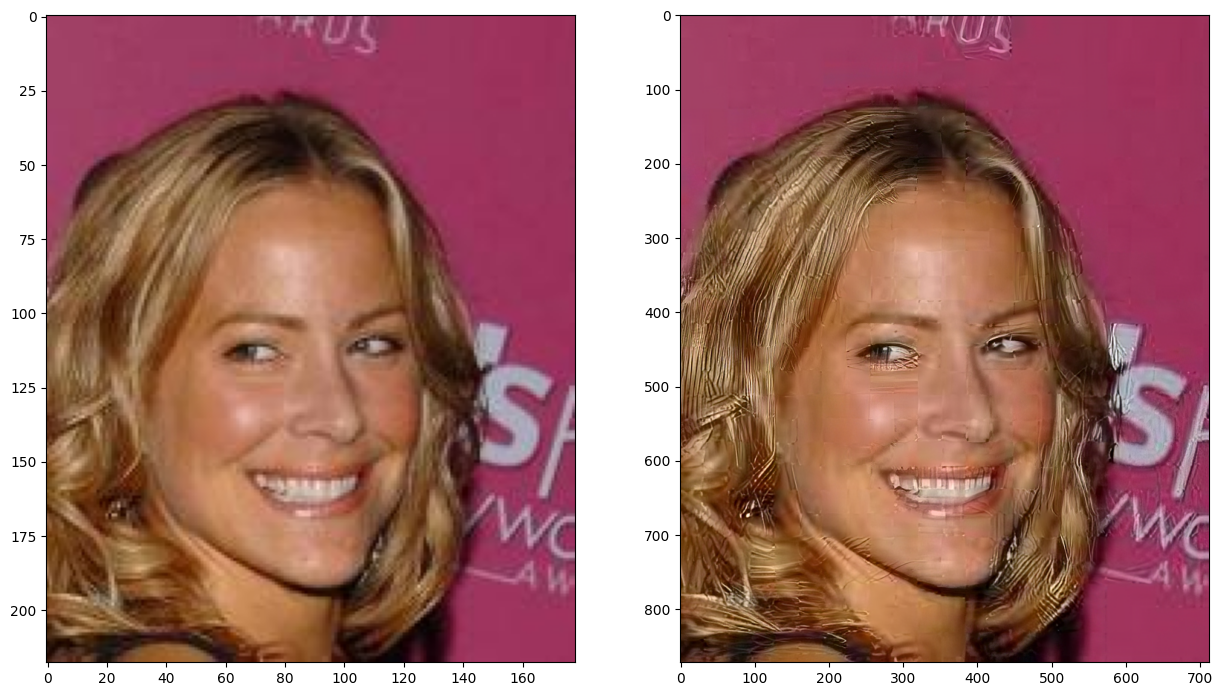

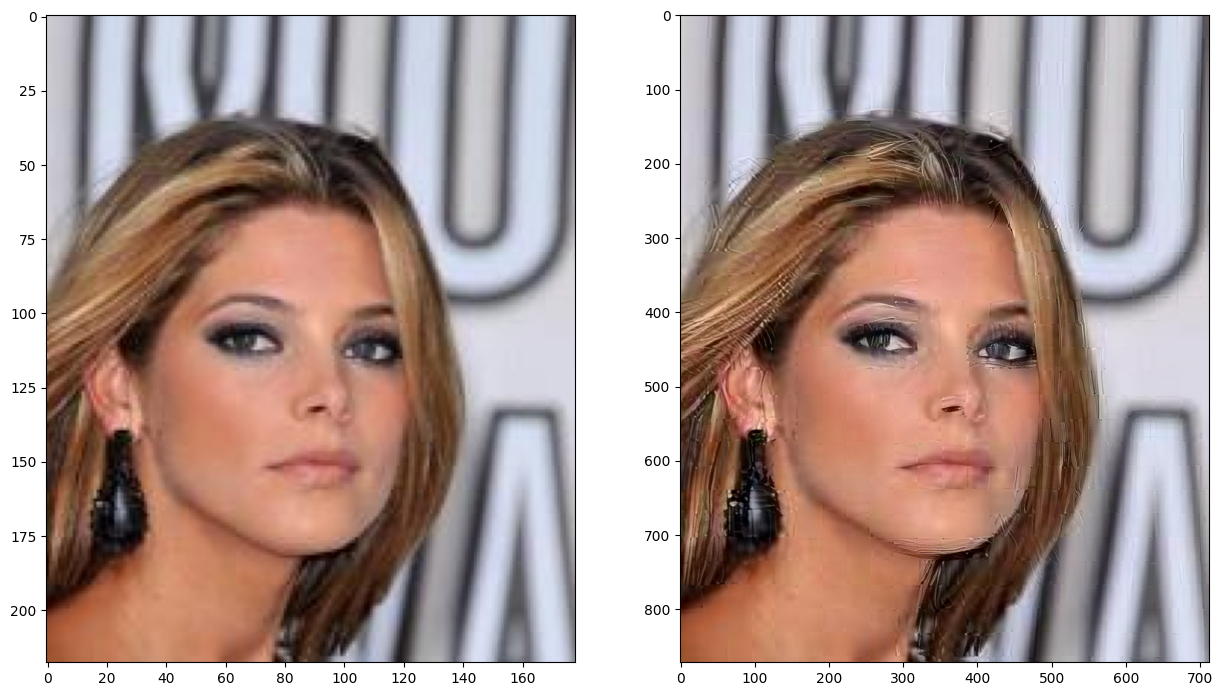

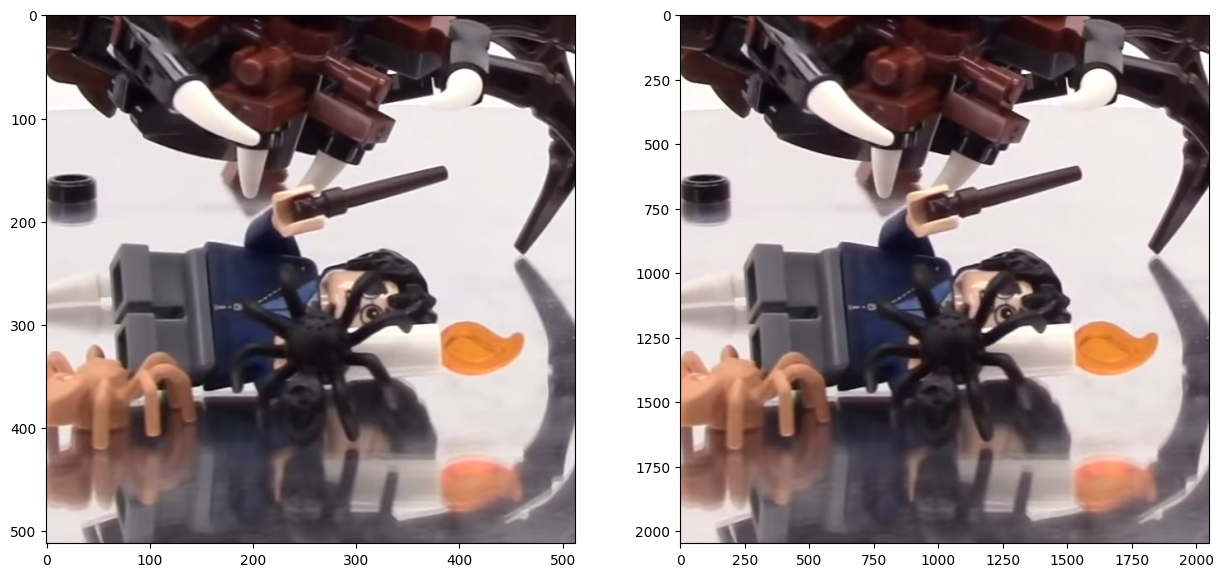

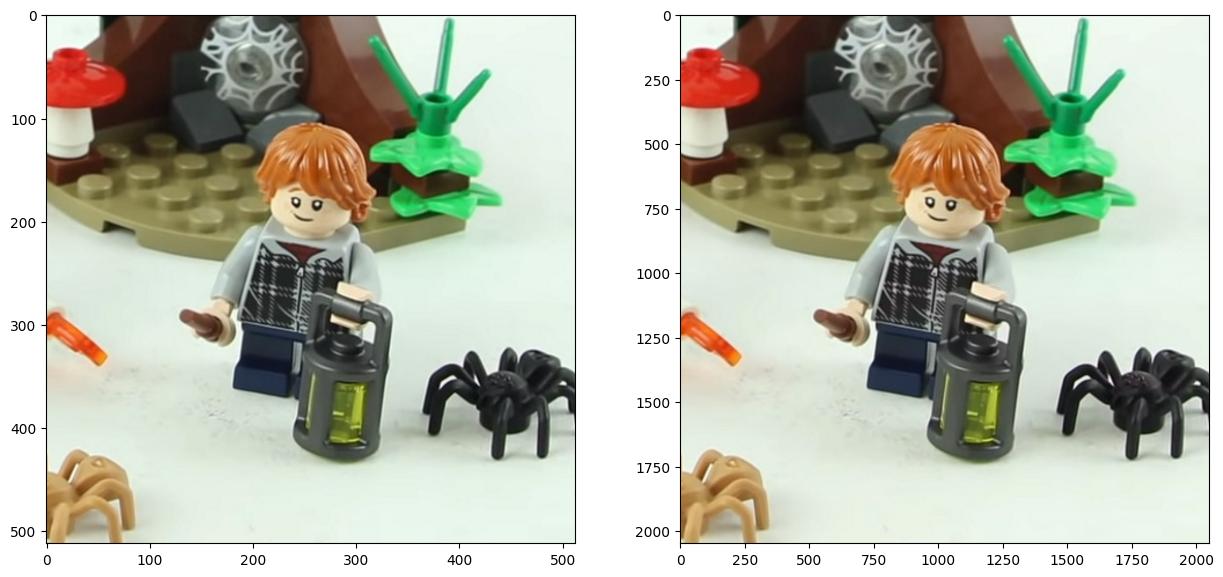

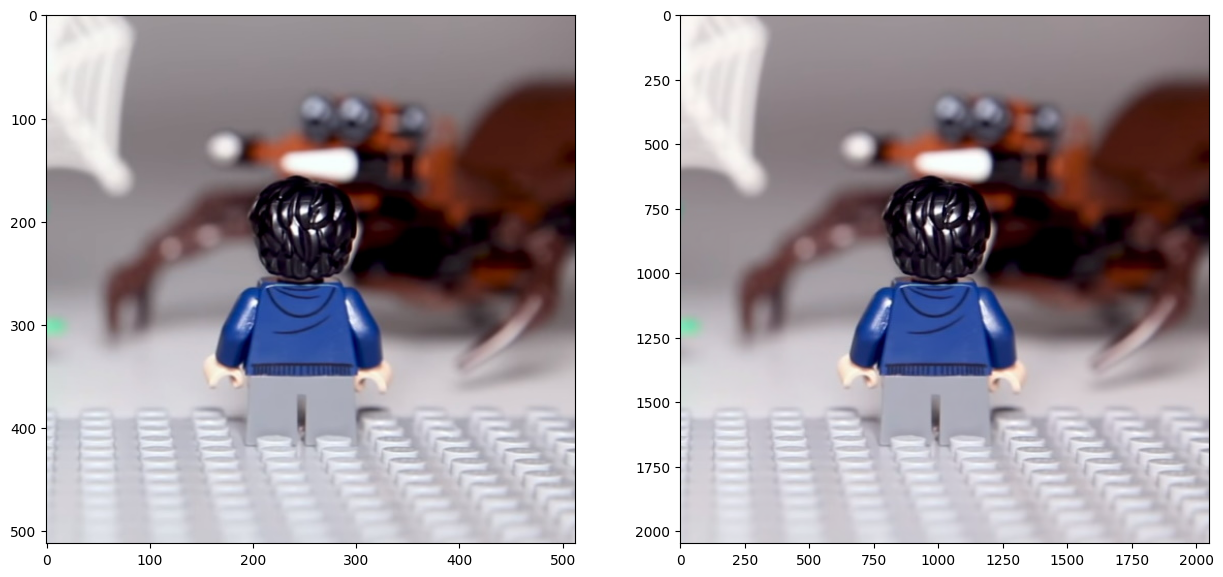

In [15]:
from torchvision.io import read_image

imgs_name = os.listdir("./LR")
for name_i in imgs_name:

    plt.figure(figsize=(15,15))

    plt.subplot(1,2,1)
    img = read_image(f"./LR/{name_i}")
    plt.imshow(np.transpose(img, (1,2,0)))
    
    
    plt.subplot(1,2,2)
    img = read_image(f"./results/{name_i[:-4]}_rlt.png")
    plt.imshow(np.transpose(img, (1,2,0)))